In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

plt.rcParams['figure.dpi'] = 700
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 13})
plt.rc('legend', fontsize=10)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=15)

In [9]:
oberservational_range = 10 # How many of the top models to consider

In [10]:
# Import price data (specifically the timeframe that is actually used for testing)
btc_price_data = pd.read_parquet('../../../2_data_processing/numeric_data/btc_numeric_data.parquet.gzip').btc_price_close.iloc[942:4219]
eth_price_data = pd.read_parquet('../../../2_data_processing/numeric_data/eth_numeric_data.parquet.gzip').eth_price_close.iloc[610:2705]

In [11]:
# Import trading data
no_nlp_btc_df = pd.read_csv(f'no_nlp_btc_{oberservational_range}.csv')
no_nlp_eth_df = pd.read_csv(f'no_nlp_eth_{oberservational_range}.csv')
pretrained_nlp_btc_df = pd.read_csv(f'pretrained_nlp_btc_{oberservational_range}.csv')
pretrained_nlp_eth_df = pd.read_csv(f'pretrained_nlp_eth_{oberservational_range}.csv')
finetuned_nlp_btc_df = pd.read_csv(f'finetuned_nlp_btc_{oberservational_range}.csv')
finetuned_nlp_eth_df = pd.read_csv(f'finetuned_nlp_eth_{oberservational_range}.csv')

# Strip redundant columns
def strip_columns(df):
    ''' Strips columns containing __MIN or __MAX '''
    return df[df.columns.drop(list(df.filter(like='__MIN'))).drop(list(df.filter(like='__MAX')))]

no_nlp_btc_df = strip_columns(no_nlp_btc_df)
no_nlp_eth_df = strip_columns(no_nlp_eth_df)
pretrained_nlp_btc_df = strip_columns(pretrained_nlp_btc_df)
pretrained_nlp_eth_df = strip_columns(pretrained_nlp_eth_df)
finetuned_nlp_btc_df = strip_columns(finetuned_nlp_btc_df)
finetuned_nlp_eth_df = strip_columns(finetuned_nlp_eth_df)

# Concat pre-trained and fine-tuned NLP data
nlp_btc_avg_df = pd.concat([pretrained_nlp_btc_df, finetuned_nlp_btc_df])
nlp_eth_avg_df = pd.concat([pretrained_nlp_eth_df, finetuned_nlp_eth_df])

In [12]:
def prepare_data(no_nlp: pd.DataFrame, nlp: pd.DataFrame):
    ''' Reshapes data into the format required by seaborn. '''
    return (
        pd.concat([no_nlp.melt(), nlp.melt()], keys=['No NLP', 'NLP'])
        .reset_index()
        .drop(columns='level_1')
        .rename(columns={
            'level_0': 'Feature set',
            'variable': 'Cross-validation fold',
            'value': 'Profit above buy-and-hold (%)'
        })
    )

In [13]:
x = no_nlp_btc_df.drop(columns='Step').T
y = nlp_btc_avg_df.drop(columns='Step').T
btc_df = prepare_data(x, y)
btc_df['Cross-validation fold'] = btc_df['Cross-validation fold'] + 1

x = no_nlp_eth_df.drop(columns='Step').T
y = nlp_eth_avg_df.drop(columns='Step').T
eth_df = prepare_data(x, y)
eth_df['Cross-validation fold'] = eth_df['Cross-validation fold'] + 1

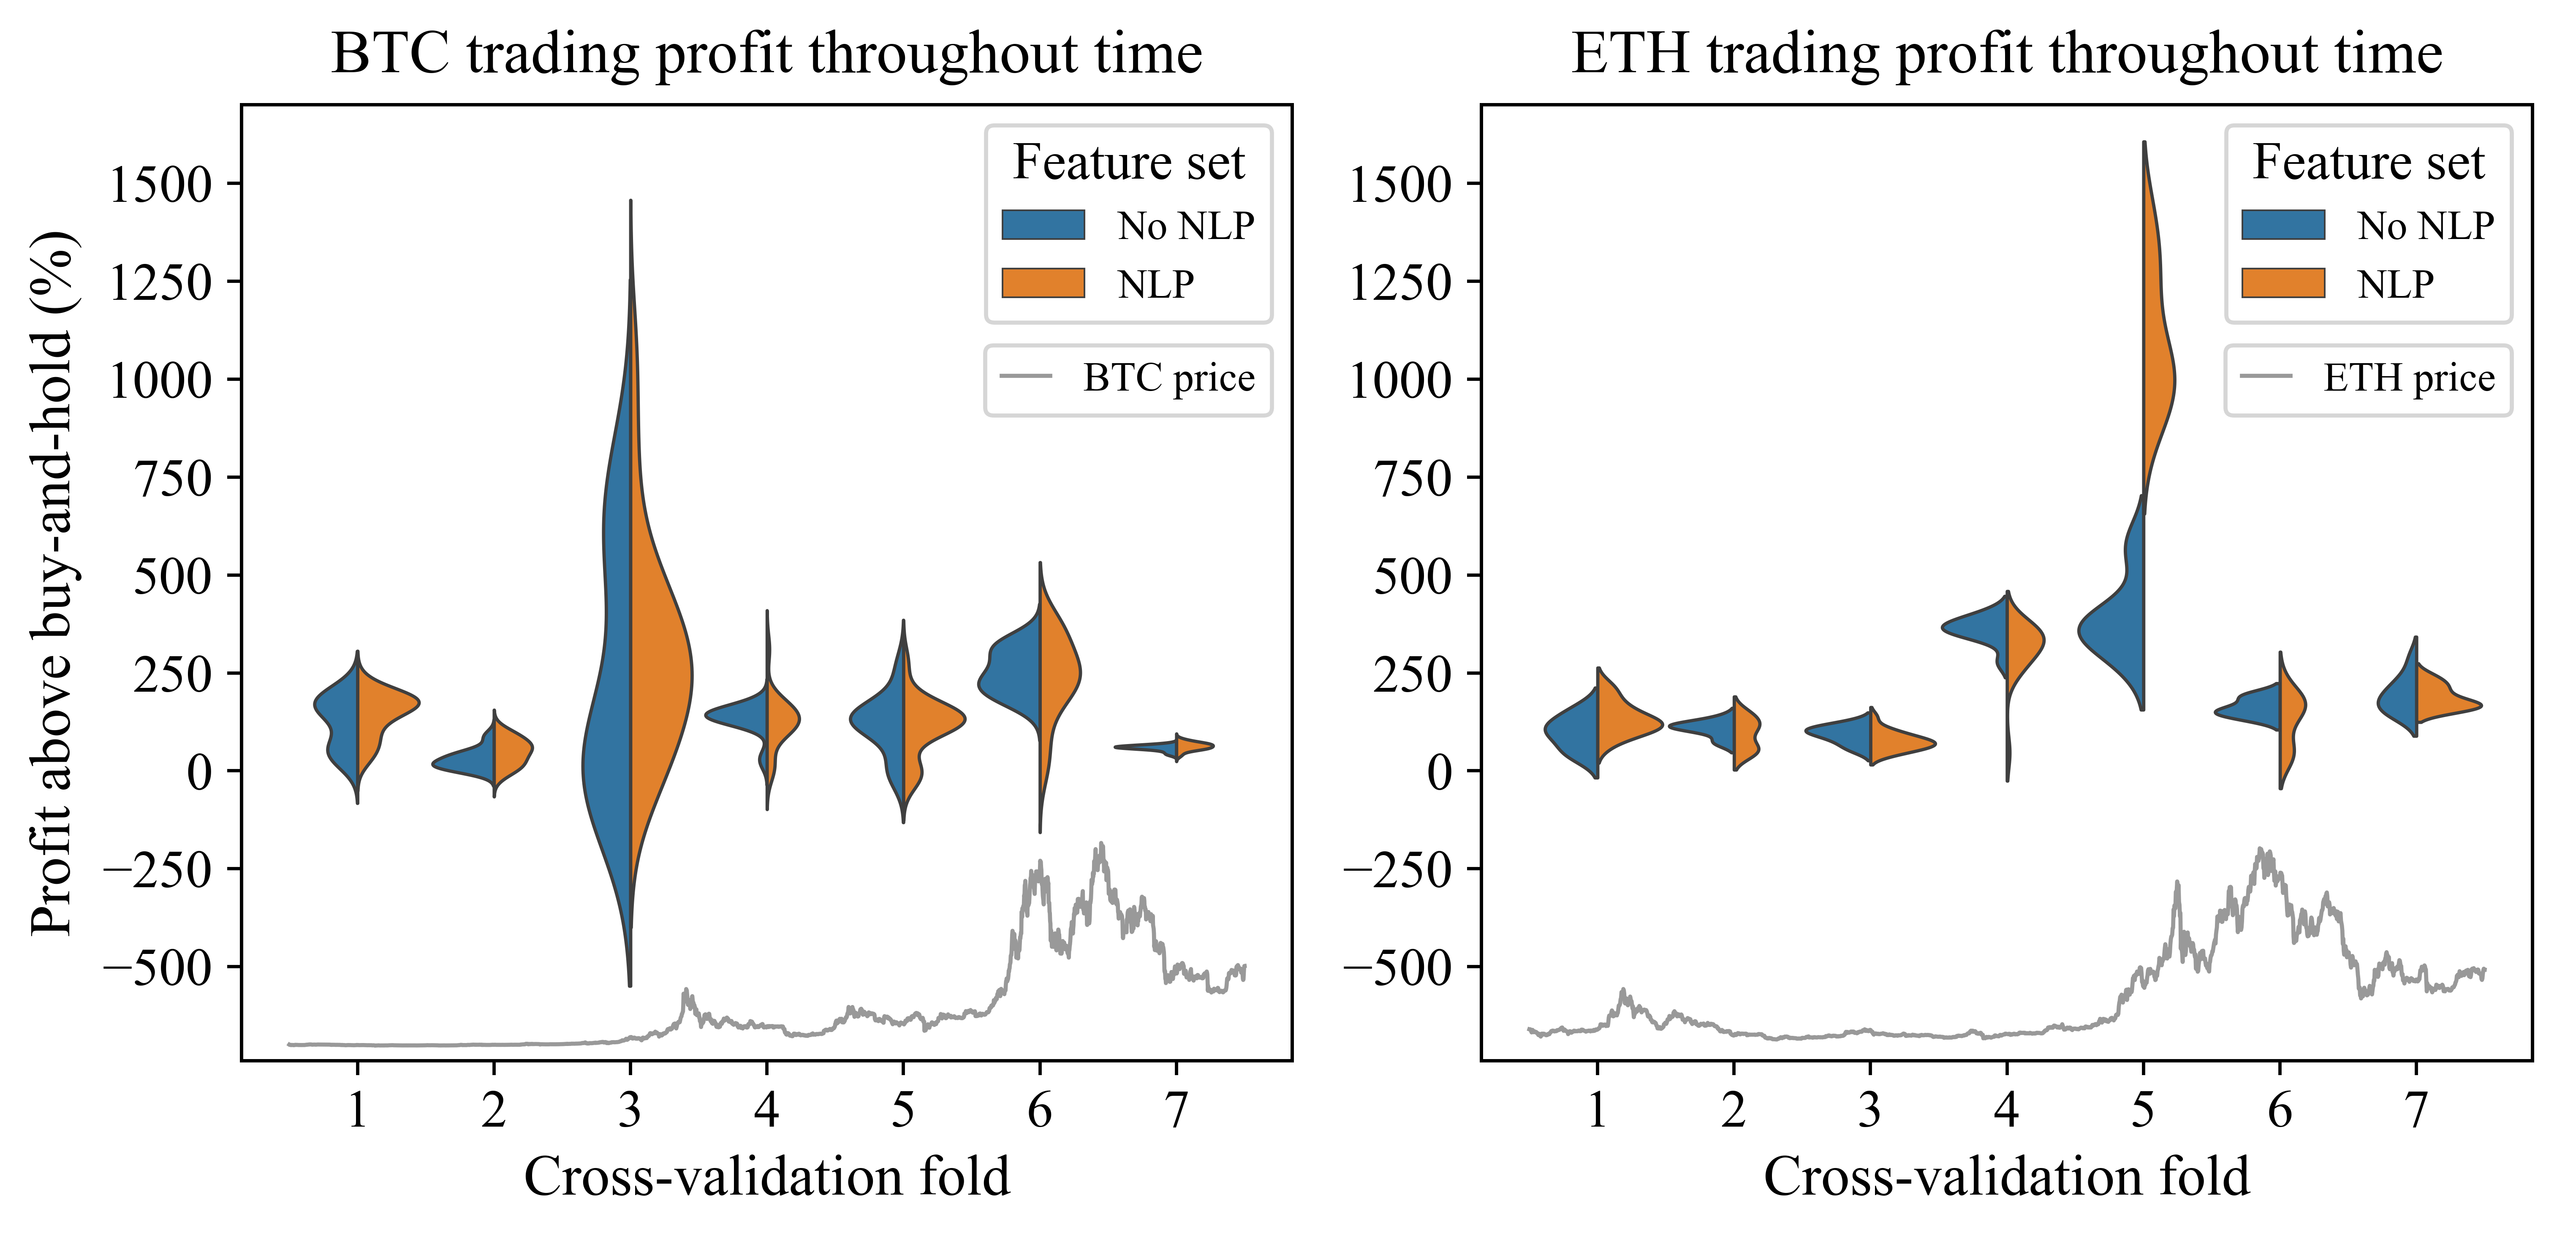

In [14]:
plt.figure(figsize=(10, 4.2))
loc = plticker.MultipleLocator(base=250)

# First violinplot
ax1 = plt.subplot(1, 2, 1)
sns.violinplot(
    data=btc_df,
    x='Cross-validation fold',
    y='Profit above buy-and-hold (%)',
    hue='Feature set',
    inner=None,
    gridsize=200,
    cut=2.7,
    split=True,
    fliersize=0,
    width=0.9,
    linewidth=0.8,
)
ax1.set_ylabel('Profit above buy-and-hold (%)', labelpad=5)
ax1.set_title('BTC trading profit throughout time', pad=8)

# Adjust y-axis
ax1.set_ylim(-740, 1700)
ax1.yaxis.set_major_locator(loc)

# Overlay BTC price lineplot
x_mapped_btc = np.linspace(-0.5, 6.5, len(btc_price_data))
ax1b = ax1.twinx()
ax1b.plot(
    x_mapped_btc,
    btc_price_data.values,
    color='grey',
    linewidth=1,
    alpha=0.8,
    label='BTC price',
)
ax1b.set_ylim(-4200, 270000)
ax1b.set_yticks([])
ax1b.set_ylabel('')

# Create legends
handles_violin, labels_violin = ax1.get_legend_handles_labels()
feature_legend = ax1.legend(
    handles=handles_violin,
    labels=labels_violin,
    title='Feature set',
    loc='upper right',
)
ax1.add_artist(feature_legend)
handles_line, labels_line = ax1b.get_legend_handles_labels()
ax1.legend(
    handles=handles_line,
    labels=labels_line,
    loc='upper right',
    bbox_to_anchor=(1, 0.77),
    handlelength=1.18,
)

# Second violinplot
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
sns.violinplot(
    data=eth_df,
    x='Cross-validation fold',
    y='Profit above buy-and-hold (%)',
    hue='Feature set',
    inner=None,
    gridsize=200,
    cut=1.8,
    split=True,
    fliersize=0,
    width=0.95,
    linewidth=0.8,
)
ax2.set_title('ETH trading profit throughout time', pad=8)

# Adjust y-axis
ax2.set_ylabel('')
# ax2.set_ylim(-490, 1700)
ax2.yaxis.set_major_locator(loc)

# Overlay ETH price lineplot
x_mapped_eth = np.linspace(-0.5, 6.5, len(eth_price_data))
ax2b = ax2.twinx()
ax2b.plot(
    x_mapped_eth,
    eth_price_data.values,
    color='grey',
    linewidth=1,
    alpha=0.8,
    label='ETH price',
)
ax2b.set_ylim(-380, 20000)
ax2b.set_yticks([])
ax2b.set_ylabel('')

# Create legends
handles_violin, labels_violin = ax2.get_legend_handles_labels()
feature_legend = ax2.legend(
    handles=handles_violin,
    labels=labels_violin,
    title='Feature set',
    loc='upper right',
)
ax2.add_artist(feature_legend)
handles_line, labels_line = ax2b.get_legend_handles_labels()
ax2.legend(
    handles=handles_line,
    labels=labels_line,
    loc='upper right',
    bbox_to_anchor=(1, 0.77),
    handlelength=1.18,
)

plt.subplots_adjust(wspace=0.18)
plt.show()